Possible datasets
 - https://data.world/crowdflower/apple-twitter-sentiment
 - https://paperswithcode.com/dataset/stocknet-1
 - https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction
 - https://www.kaggle.com/datasets/thedevastator/tweet-sentiment-s-impact-on-stock-returns
 - https://ieee-dataport.org/open-access/stock-market-tweets-data
 - https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset
 - https://www.kaggle.com/datasets/kazanova/sentiment140
 - https://www.kaggle.com/datasets/sixlack/finaldf (using)
 - https://www.kaggle.com/datasets/utkarshxy/stock-markettweets-lexicon-data (using)
 - https://www.kaggle.com/datasets/sidarcidiacono/news-sentiment-analysis-for-stock-data-by-company/data (using)
 - https://ieee-dataport.org/open-access/stock-market-tweets-data (not good)
 - https://redu.unicamp.br/dataset.xhtml?persistentId=doi:10.25824/redu/GFJHFK (not good)

In [1]:
import os
import re
import time
import numpy as np
import pandas as pd
from collections import Counter
from multiprocessing import Pool
import multiprocessing

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.models import Word2Vec
from torchtext.data import get_tokenizer
import torchtext
import fasttext

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score, f1_score
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
# import kaggle

import helper_data, helper_model

# nltk.download('stopwords')

c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Steven\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Steven\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !pip install fasttext

## Loading:

In [3]:
# new_directory = "/content/sample_data/"
# os.chdir(new_directory)

In [4]:
RANDOM_STATE = 2023
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
SEQUENCE_LENGTH = 300
CURRENT_DIRECTORY = os.getcwd()
W2V_SIZE = 300
NUM_CORE = multiprocessing.cpu_count()
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10


In [5]:
# DATASETS = [
#     {
#         'name': "training.1600000.processed.noemoticon.csv",
#         'api': "kazanova/sentiment140",
#         'location': "data",
#         'url': "https://www.kaggle.com/datasets/kazanova/sentiment140"
#     },
#     {
#         'name': "reddit_wsb.csv",
#         'api': "gpreda/reddit-wallstreetsbets-posts",
#         'location': "data",
#         'url': "https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts"
#     },
#     {
#         'name': "stock_data.csv",
#         'api': "yash612/stockmarket-sentiment-dataset",
#         'location': "data",
#         'url': "https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset"
#     },
#     {
#         'name': "stock_tweets.csv",
#         'api': "equinxx/stock-tweets-for-sentiment-analysis-and-prediction",
#         'location': "data/unorganized/Stock Tweets for Sentiment Analysis and Prediction",
#         'url': "https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction"
#     },
#     {
#         'name': "Company_Tweet.csv",
#         'api': "omermetinn/tweets-about-the-top-companies-from-2015-to-2020",
#         'location': "data/unorganized/Tweets about the Top Companies from 2015 to 2020",
#         'url': "https://www.kaggle.com/datasets/omermetinn/tweets-about-the-top-companies-from-2015-to-2020"
#     },
#     {
#         'name': "stockerbot-export.csv",
#         'api': "davidwallach/financial-tweets",
#         'location': "data/unorganized/Financial Tweets",
#         'url': "https://www.kaggle.com/datasets/davidwallach/financial-tweets"
#     }
# ]

# for dataset_info in DATASETS:
#     dataset_name = dataset_info['name']
#     dataset_location = dataset_info['location']

#     if not os.path.exists(os.path.join(dataset_info['location'], dataset_name)):
#         print(f"Downloading {dataset_name} from {dataset_info['url']} to {dataset_location}...")
#         kaggle.api.dataset_download_files(dataset_info['api'], path=dataset_location, unzip=True)


In [6]:
dataset_filename = {
    '0': ("training.1600000.processed.noemoticon.csv", ["target", "ids", "date", "flag", "user", "text"]),
    '1': ("stock_data.csv", ["text", "target"]),
    '2': ("nasdaq.csv", ["Label", "Ticker", "Headline"]), # 0 negative, 1 positive, 2 neural
    '3': ("djia_news copy.csv", ["Label", "Ticker", "Headline"]), # 0 negative, 1 positive, 2 neural
    '4': ("data-3.csv", ["Sentence", "Sentiment"]),
    '5': ("sentiment.csv", ["Stock Ticker", "Tweet Text", "Sentiment", "Tweet URL"]),
    '6': ('train_tweet.csv', ["id", "label", "tweet"])  # 0 positive, 1 negative
}

In [7]:
dataset_path = os.path.join("", "data", dataset_filename["0"][0])
df0 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["0"][1])
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
df0.target = df0.target.apply(lambda x: decode_map[int(x)])
df0 = df0[['text', 'target']]

dataset_path = os.path.join("", "data", dataset_filename["1"][0])
df1 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["1"][1], skiprows=1)
df1.rename(columns={df1.columns[0]: 'text'}, inplace=True)
decode_map = {-1: "NEGATIVE", 1: "POSITIVE"}
df1.target = df1.target.apply(lambda x: decode_map[int(x)])

dataset_path = os.path.join("", "data", dataset_filename["2"][0])
df2 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["2"][1], skiprows=1)
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 1: "POSITIVE"}
df2['target'] = df2['Label'].apply(lambda x: decode_map[int(x)])
df2 = df2[['Headline', 'target']]
df2.rename(columns={df2.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["3"][0])
df3 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["3"][1], skiprows=1)
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 1: "POSITIVE"}
df3['target'] = df3['Label'].apply(lambda x: decode_map[int(x)])
df3 = df3[['Headline', 'target']]
df3.rename(columns={df3.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["4"][0])
df4 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["4"][1], skiprows=1)
decode_map = {"negative": "NEGATIVE", "neutral": "NEUTRAL", "positive": "POSITIVE"}
df4['target'] = df4['Sentiment'].apply(lambda x: decode_map[x])
df4.drop(columns=['Sentiment'], inplace=True)
df4.rename(columns={df4.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["5"][0])
df5 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["5"][1], skiprows=1)
decode_map = {"Negative": "NEGATIVE", "Positive": "POSITIVE"}
df5['target'] = df5['Sentiment'].apply(lambda x: decode_map[x])
df5 = df5[['Tweet Text', 'target']]
df5.rename(columns={df5.columns[0]: 'text'}, inplace=True)

dataset_path = os.path.join("", "data", dataset_filename["6"][0])
df6 = pd.read_csv(dataset_path, encoding=DATASET_ENCODING, names=dataset_filename["6"][1], skiprows=1)
decode_map = {0: "POSITIVE", 1: "NEGATIVE"}
df6['target'] = df6['label'].apply(lambda x: decode_map[int(x)])
df6 = df6[['tweet', 'target']]
df6.rename(columns={df6.columns[0]: 'text'}, inplace=True)

In [8]:
total_rows = len(df0) + len(df2) + len(df3) + len(df4) + len(df5) + len(df6)
print("Total number of rows:", total_rows)

Total number of rows: 1653866


In [9]:
df = pd.concat([df0, df2, df3, df4, df5, df6], ignore_index=True)
df.shape

(1653866, 2)

In [10]:
df = helper_data.shuffle_dataframe(df)

In [11]:
top_10 = df.head(200)
last_10 = df.tail(200) 
df = pd.concat([top_10, last_10])

In [12]:
df = df[df['target'] != "NEUTRAL"]

In [13]:
df[:-10]

,text,target
1125454,@gatsbycoram really??? So does having one @ ag...,POSITIVE
280475,"@honigkeks I'm working that weekend, and no on...",NEGATIVE
1468649,@MiaAlien Exactly that is why I do the music I...,POSITIVE
954709,@_alittlebird_ thank you that's why I married...,POSITIVE
1480740,just wrote a song for all my friends here in i...,POSITIVE
...,...,...
211077,@kgalyon nooooooo don't say that,NEGATIVE
40149,@kyriDMB why did I go to bed so late last nigh...,NEGATIVE
1050342,"@JonathanRKnight ok, I'm in the Coast Guard an...",POSITIVE
1356289,@magicmaid they make me feel kind of stabby ...,POSITIVE


## Preprocessing:

In [14]:
%%time
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

def preprocess(text, stem=False):
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = [word for word in text.split() if word not in stop_words]
    if stem:
        tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)

df.text = df.text.apply(lambda x: preprocess(x))

CPU times: total: 0 ns
Wall time: 16.5 ms


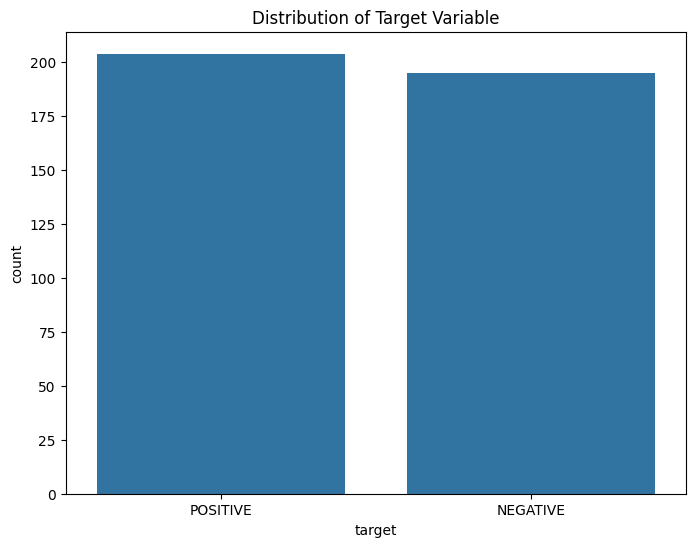

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='target')
plt.title('Distribution of Target Variable')
plt.show()

In [16]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=RANDOM_STATE)

### Fasttext and Word2vec Training: https://www.analyticsvidhya.com/blog/2023/01/introduction-to-fasttext-embeddings-and-its-implication/

In [17]:
%%time
CURRENT_DIRECTORY = os.getcwd()
MODEL_PATH = os.path.join(CURRENT_DIRECTORY, "fasttext_model.bin")
TRAINING_DATA_PATH = os.path.join(CURRENT_DIRECTORY, "fasttext_train.txt")

if os.path.isfile(MODEL_PATH):
    fasttext_model = fasttext.load_model(MODEL_PATH)
else:
    sentences = [row.split() for row in df_train['text']]
    with open(TRAINING_DATA_PATH, "w") as f:
        for sentence in sentences:
            f.write(" ".join(sentence) + "\n")
    fasttext_model = fasttext.train_unsupervised(TRAINING_DATA_PATH, model='skipgram')
    fasttext_model.save_model(MODEL_PATH)


CPU times: total: 594 ms
Wall time: 1.74 s


In [18]:
# %%time
# MODEL_PATH = os.path.join(CURRENT_DIRECTORY, "word2vec_model.model")

# if os.path.isfile(MODEL_PATH):
#     w2v_model = Word2Vec.load(MODEL_PATH)
# else:
#     sentences = [row.split() for row in df_train['text']]
#     w2v_model = Word2Vec(sentences, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=NUM_CORE)
#     w2v_model.build_vocab(sentences)
#     w2v_model.train(sentences, total_examples=len(documents), epochs=W2V_EPOCH)
#     w2v_model.save(MODEL_PATH)

### Tokenization:

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1

x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

### Embedding Layer:

In [20]:
%%time
EMBEDDING_DIM = fasttext_model.get_dimension()
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    embedding_matrix[i] = fasttext_model.get_word_vector(word)

CPU times: total: 46.9 ms
Wall time: 71.5 ms


In [21]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist()).reshape(-1,1)
y_test = encoder.transform(df_test.target.tolist()).reshape(-1,1)

## Preparation for PyTorch Model:

In [22]:
BATCH_SIZE = 128
train_dataset = helper_model.TextDataset(x_train, y_train)
test_dataset = helper_model.TextDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [24]:
directory_path = 'model'
helper_model.clean_directory(directory_path)

Deleted: model\rnn_bs128_epoch1.pt
Deleted: model\rnn_bs128_epoch2.pt
Deleted: model\rnn_bs128_epoch3.pt
Deleted: model\rnn_bs128_epoch4.pt
Deleted: model\rnn_bs128_epoch5.pt
Deleted: model\rnn_bs128_epoch6.pt


In [25]:
helper_model.train(train_loader, test_loader, embedding_matrix, BATCH_SIZE, num_epochs=6, learning_rate=0.001, save_path="model/")

Epoch 1/6: 100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


Epoch 1, Loss: 0.6922532320022583, Accuracy: 0.5625


Epoch 2/6: 100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


Epoch 2, Loss: 0.6865310271581014, Accuracy: 0.6125


Epoch 3/6: 100%|██████████| 3/3 [00:05<00:00,  1.82s/it]


Epoch 3, Loss: 0.6816229025522867, Accuracy: 0.6625


Epoch 4/6: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]


Epoch 4, Loss: 0.6754637360572815, Accuracy: 0.6500


Epoch 5/6:  33%|███▎      | 1/3 [00:02<00:04,  2.03s/it]

In [ ]:
model = helper_model.SentimentClassifier(embedding_matrix) 
model_path = 'model\\rnn_bs128_epoch6.pt'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

## Evaluate

In [ ]:
mislabeled_examples = helper_model.evaluate_model(model, test_loader, y_test, embedding_matrix, df_test["text"], threshold=0.5)

Accuracy: 0.5909
F1-Score: 0.3077
ROC-AUC: 0.7323


NameError: name 'np' is not defined

## True Validation

In [ ]:
# Load and preprocess the stock dataset
stock_dataset_path = os.path.join("", "data", dataset_filename["1"][0])
stock_df = pd.read_csv(stock_dataset_path, encoding=DATASET_ENCODING)
stock_df = stock_df.rename(columns={"Text": "text", "Sentiment": "target"})
stock_df['text'] = stock_df['text'].apply(preprocess)
x_stock = pad_sequences(tokenizer.texts_to_sequences(stock_df['text']), maxlen=SEQUENCE_LENGTH)
stock_dataset = helper_model.TextDataset(x_stock, np.zeros_like(x_stock))
stock_loader = DataLoader(stock_dataset, batch_size=BATCH_SIZE, shuffle=False)
stock_df["target"] = stock_df["target"].map({-1: "NEGATIVE", 1: "POSITIVE"})
y_stock = encoder.transform(stock_df['target'].tolist()).reshape(-1, 1)


ValueError: y contains previously unseen labels: 'POSITIVE'

In [ ]:
res_stock = helper_model.evaluate_model(model, test_loader, y_test, embedding_matrix, df_test["text"], threshold=0.5)

Accuracy: 1.0000
F1-Score: 0.0000


c:\Users\Steven\anaconda3\envs\stock\lib\site-packages\sklearn\metrics\_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [ ]:
mislabels = res_stock
short_texts, texts_with_not, other_errors = helper_model.categorize_errors(mislabels)
helper_model.quantify_errors(short_texts, texts_with_not, other_errors)
helper_model.deep_dive(short_texts, texts_with_not)


NameError: name 'res_stock' is not defined

In [ ]:
helper_model.print_mislabeled_examples(res_stock)


Example 1:
Original Text: user afraid short amzn looking like near monopoly ebooks infrastructure service
Predicted Label: 0
True Label: 1


Example 2:
Original Text: oi 21 37
Predicted Label: 0
True Label: 1


Example 3:
Original Text: aap user current downtrend break otherwise short term correction med term downtrend
Predicted Label: 1
True Label: 0


Example 4:
Original Text: monday relative weakness nyx win tie tap ice int bmc aon c chk biib
Predicted Label: 1
True Label: 0


Example 5:
Original Text: assuming fcx opens tomorrow 34 25 trigger buy still much like setup
Predicted Label: 0
True Label: 1


Example 6:
Original Text: momentum coming back etfc broke ma200 resistance solid volume friday ong set
Predicted Label: 0
True Label: 1


Example 7:
Original Text: swy 30 float short breaking ouch
Predicted Label: 0
True Label: 1


Example 8:
Original Text: biof wants 4 90 comin
Predicted Label: 0
True Label: 1


Example 9:
Original Text: red ready break
Predicted Label: 1
True Label